In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "high_z"
key = "lambda"
quantile = "2"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

12it [00:00, 118.98it/s]

27it [00:00, 124.88it/s]

42it [00:00, 129.39it/s]

52it [00:00, 118.47it/s]

62it [00:00, 109.43it/s]

76it [00:00, 116.60it/s]

91it [00:00, 122.75it/s]

105it [00:00, 126.89it/s]

120it [00:00, 130.70it/s]

133it [00:01, 124.84it/s]

146it [00:01, 126.33it/s]

160it [00:01, 128.37it/s]

174it [00:01, 129.79it/s]

187it [00:01, 126.71it/s]

200it [00:01, 115.69it/s]

212it [00:01, 106.55it/s]

224it [00:01, 109.63it/s]

238it [00:01, 116.84it/s]

252it [00:02, 122.76it/s]

266it [00:02, 127.15it/s]

280it [00:02, 130.70it/s]

295it [00:02, 133.29it/s]

309it [00:02, 120.11it/s]

323it [00:02, 124.82it/s]

337it [00:02, 128.59it/s]

351it [00:02, 130.88it/s]

365it [00:02, 128.97it/s]

379it [00:03, 120.06it/s]

392it [00:03, 109.72it/s]

404it [00:03, 103.12it/s]

416it [00:03, 105.77it/s]

430it [00:03, 111.07it/s]

442it [00:03, 105.12it/s]

453it [00:03, 106.22it/s]

467it [00:03, 113.80it/s]

481it [00:03, 118.89it/s]

495it [00:04, 122.50it/s]

509it [00:04, 127.24it/s]

522it [00:04, 109.02it/s]

534it [00:04, 102.09it/s]

545it [00:04, 98.40it/s] 

559it [00:04, 107.57it/s]

573it [00:04, 115.20it/s]

587it [00:04, 120.92it/s]

602it [00:05, 126.40it/s]

616it [00:05, 129.95it/s]

631it [00:05, 133.14it/s]

646it [00:05, 134.91it/s]

660it [00:05, 135.52it/s]

674it [00:05, 136.24it/s]

688it [00:05, 137.25it/s]

702it [00:05, 130.72it/s]

716it [00:05, 128.31it/s]

729it [00:05, 128.24it/s]

742it [00:06, 126.98it/s]

755it [00:06, 123.52it/s]

768it [00:06, 111.58it/s]

781it [00:06, 115.05it/s]

793it [00:06, 116.13it/s]

806it [00:06, 119.06it/s]

819it [00:06, 112.18it/s]

833it [00:06, 118.63it/s]

847it [00:06, 123.00it/s]

861it [00:07, 127.26it/s]

875it [00:07, 129.31it/s]

890it [00:07, 132.91it/s]

904it [00:07, 127.70it/s]

919it [00:07, 131.48it/s]

934it [00:07, 134.17it/s]

948it [00:07, 135.67it/s]

962it [00:07, 135.49it/s]

976it [00:07, 136.08it/s]

990it [00:08, 136.58it/s]

1004it [00:08, 118.69it/s]

1018it [00:08, 124.36it/s]

1032it [00:08, 128.08it/s]

1046it [00:08, 118.36it/s]

1061it [00:08, 124.22it/s]

1075it [00:08, 128.46it/s]

1089it [00:08, 131.15it/s]

1104it [00:08, 132.68it/s]

1118it [00:09, 133.64it/s]

1132it [00:09, 135.29it/s]

1146it [00:09, 131.39it/s]

1160it [00:09, 130.92it/s]

1174it [00:09, 122.93it/s]

1187it [00:09, 106.10it/s]

1199it [00:09, 108.03it/s]

1212it [00:09, 111.55it/s]

1224it [00:09, 110.14it/s]

1237it [00:10, 114.87it/s]

1250it [00:10, 117.91it/s]

1256it [00:10, 122.70it/s]


0it [00:00, ?it/s]

9it [00:00, 83.89it/s]

Number of empty sat catalogs is 0


18it [00:00, 84.09it/s]

32it [00:00, 95.04it/s]

42it [00:00, 96.21it/s]

56it [00:00, 105.20it/s]

68it [00:00, 107.75it/s]

82it [00:00, 115.33it/s]

97it [00:00, 122.17it/s]

112it [00:00, 127.59it/s]

127it [00:01, 131.20it/s]

141it [00:01, 130.68it/s]

155it [00:01, 113.78it/s]

169it [00:01, 120.18it/s]

184it [00:01, 125.50it/s]

198it [00:01, 126.09it/s]

213it [00:01, 130.87it/s]

228it [00:01, 133.87it/s]

243it [00:01, 136.43it/s]

258it [00:02, 138.00it/s]

272it [00:02, 138.43it/s]

287it [00:02, 139.31it/s]

301it [00:02, 116.14it/s]

314it [00:02, 119.50it/s]

328it [00:02, 123.61it/s]

342it [00:02, 125.58it/s]

355it [00:02, 124.60it/s]

369it [00:02, 127.68it/s]

382it [00:03, 114.65it/s]

394it [00:03, 108.76it/s]

408it [00:03, 115.94it/s]

421it [00:03, 119.71it/s]

436it [00:03, 126.65it/s]

451it [00:03, 130.93it/s]

466it [00:03, 132.73it/s]

480it [00:03, 126.66it/s]

493it [00:03, 115.47it/s]

505it [00:04, 108.29it/s]

520it [00:04, 117.52it/s]

533it [00:04, 106.51it/s]

545it [00:04, 107.37it/s]

559it [00:04, 114.64it/s]

571it [00:04, 106.83it/s]

583it [00:04, 100.86it/s]

597it [00:04, 109.65it/s]

611it [00:05, 116.89it/s]

624it [00:05, 110.34it/s]

639it [00:05, 119.16it/s]

654it [00:05, 125.69it/s]

669it [00:05, 130.16it/s]

684it [00:05, 134.84it/s]

699it [00:05, 138.01it/s]

714it [00:05, 139.08it/s]

729it [00:05, 140.07it/s]

744it [00:06, 135.48it/s]

758it [00:06, 135.52it/s]

772it [00:06, 136.55it/s]

787it [00:06, 139.48it/s]

802it [00:06, 139.87it/s]

817it [00:06, 134.99it/s]

831it [00:06, 120.44it/s]

845it [00:06, 124.47it/s]

860it [00:06, 130.04it/s]

874it [00:07, 124.93it/s]

887it [00:07, 125.97it/s]

902it [00:07, 130.93it/s]

917it [00:07, 135.62it/s]

932it [00:07, 139.16it/s]

947it [00:07, 139.08it/s]

962it [00:07, 140.78it/s]

977it [00:07, 141.87it/s]

992it [00:07, 140.58it/s]

1007it [00:07, 137.59it/s]

1022it [00:08, 138.92it/s]

1036it [00:08, 138.13it/s]

1051it [00:08, 140.97it/s]

1066it [00:08, 143.30it/s]

1081it [00:08, 142.78it/s]

1096it [00:08, 143.82it/s]

1111it [00:08, 144.55it/s]

1126it [00:08, 145.31it/s]

1141it [00:08, 145.83it/s]

1156it [00:09, 139.96it/s]

1171it [00:09, 140.75it/s]

1186it [00:09, 141.03it/s]

1201it [00:09, 129.40it/s]

1216it [00:09, 133.56it/s]

1230it [00:09, 113.51it/s]

1242it [00:09, 109.41it/s]

1256it [00:09, 127.38it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

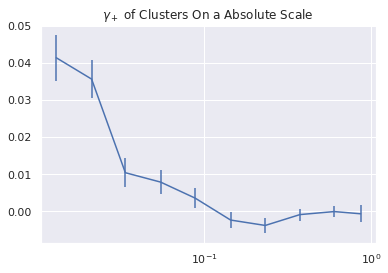

Aggregated xi:
[-10.988  -20.9616  -9.6726 -12.6965  -9.2185   9.8632  24.4971   7.7116
   0.2666   2.9828]
------------------------------------------------------------------------------
Aggregated meanlogr:
[-1148.8869 -2259.8486 -3131.6495 -4648.6788 -6227.6828 -8260.7775
 -9498.0517 -9035.5976 -5397.7498  -710.8072]
------------------------------------------------------------------------------
Aggregated npairs:
[  265.   587.   925.  1603.  2569.  4263.  6500.  9184. 10537.  4770.]
------------------------------------------------------------------------------
Mean xi:
[-4.1464e-02 -3.5710e-02 -1.0457e-02 -7.9205e-03 -3.5884e-03  2.3137e-03
  3.7688e-03  8.3968e-04  2.5298e-05  6.2532e-04]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3354 -3.8498 -3.3856 -2.9    -2.4242 -1.9378 -1.4612 -0.9838 -0.5123
 -0.149 ]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

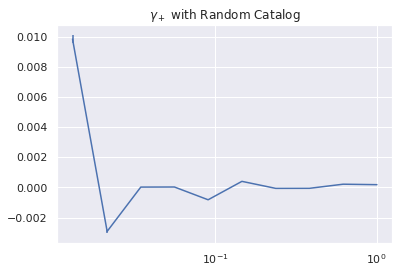

[ 9.8275e-03 -2.9159e-03  1.9740e-05  2.5301e-05 -8.2103e-04  3.9983e-04
 -6.5348e-05 -6.1656e-05  2.1127e-04  1.8010e-04]
[-2.7730e-04  8.2276e-05 -5.5699e-07 -7.1392e-07  2.3167e-05 -1.1282e-05
  1.8439e-06  1.7397e-06 -5.9613e-06 -5.0818e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

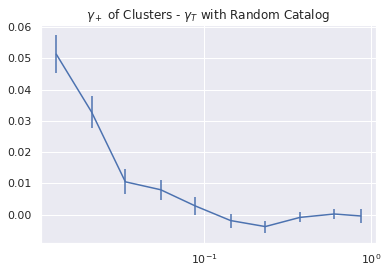

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

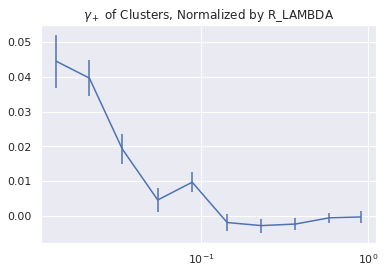

Aggregated xi:
[ -8.1477 -17.3391 -15.4448  -6.0778 -21.4119   6.6564  15.5387  18.8564
   5.4434   2.482 ]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -788.7933 -1683.5727 -2718.6808 -3842.6239 -5355.7234 -6849.8542
 -8274.6142 -8116.603  -5523.7939  -858.4959]
------------------------------------------------------------------------------
Aggregated npairs:
[  183.   437.   800.  1322.  2204.  3520.  5609.  8103. 10388.  8668.]
------------------------------------------------------------------------------
Mean xi:
[-0.0445 -0.0397 -0.0193 -0.0046 -0.0097  0.0019  0.0028  0.0023  0.0005
  0.0003]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3103 -3.8526 -3.3984 -2.9067 -2.43   -1.946  -1.4752 -1.0017 -0.5317
 -0.099 ]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)